In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout,Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and preprocess the data
df = pd.read_csv('dataset.csv')
for col in df.select_dtypes(include=[object]):
    df[col] = df[col].str.replace('_', ' ')

In [3]:
#Remove the trailing space from the symptom columns
cols = df.columns
data = df[cols].values.flatten()

s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns=df.columns)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin rash,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin rash,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin rash,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin rash,nodal skin eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['combined_symptoms'] = df[df.columns[1:]].apply(lambda row: ','.join(row.dropna().astype(str)), axis=1)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,combined_symptoms
0,Fungal infection,itching,skin rash,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"itching,skin rash,nodal skin eruptions,dischro..."
1,Fungal infection,skin rash,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"skin rash,nodal skin eruptions,dischromic pat..."
2,Fungal infection,itching,nodal skin eruptions,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"itching,nodal skin eruptions,dischromic patches"
3,Fungal infection,itching,skin rash,dischromic patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"itching,skin rash,dischromic patches"
4,Fungal infection,itching,skin rash,nodal skin eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"itching,skin rash,nodal skin eruptions"


In [5]:
label_encoder = LabelEncoder()
df['disease_encoded'] = label_encoder.fit_transform(df['Disease'])

In [6]:
X = df['combined_symptoms']
y = df['disease_encoded']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_bow = tokenizer.texts_to_matrix(X_train, mode='tfidf')
X_test_bow = tokenizer.texts_to_matrix(X_test, mode='tfidf')

In [9]:
max_length = 150
X_train_bow = tf.keras.preprocessing.sequence.pad_sequences(X_train_bow, maxlen=max_length, padding='post', truncating='post')
X_test_bow = tf.keras.preprocessing.sequence.pad_sequences(X_test_bow, maxlen=max_length, padding='post', truncating='post')

In [10]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=512, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    GlobalAveragePooling1D(),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = Adam(lr=0.001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 512)          107008    
                                                                 
 conv1d (Conv1D)             (None, 150, 128)          196736    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

In [11]:
#Train the model
history = model.fit(X_train_bow, y_train, batch_size=32, epochs=50, validation_split=0.1, callbacks=[lr_scheduler])
# Save the model
model.save('disease_prediction_model.h5')

Epoch 1/50
125/125 [==============================] - 4s 12ms/step - loss: 2.9101 - accuracy: 0.1787 - val_loss: 1.4125 - val_accuracy: 0.5237 - lr: 0.0010
Epoch 2/50
125/125 [==============================] - 1s 10ms/step - loss: 1.1187 - accuracy: 0.5975 - val_loss: 0.7274 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 3/50
125/125 [==============================] - 1s 9ms/step - loss: 0.7427 - accuracy: 0.7415 - val_loss: 0.5355 - val_accuracy: 0.8284 - lr: 0.0010
Epoch 4/50
125/125 [==============================] - 1s 10ms/step - loss: 0.5845 - accuracy: 0.7907 - val_loss: 0.4562 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 5/50
125/125 [==============================] - 1s 10ms/step - loss: 0.4902 - accuracy: 0.8314 - val_loss: 0.3956 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 6/50
125/125 [==============================] - 1s 10ms/step - loss: 0.4233 - accuracy: 0.8572 - val_loss: 0.3630 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 7/50
125/125 [==============================] - 1s 9ms/step

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_bow, y_test)
print(f'Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 5ms/step - loss: 0.0156 - accuracy: 0.9939
Test Accuracy: 0.9939024448394775


In [13]:
y_pred = model.predict(X_test_bow)
y_pred_classes = np.argmax(y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_test, y_pred_classes, target_names=df['Disease'].unique()))

16/16 [==============================] - 0s 3ms/step
Classification Report:
                                         precision    recall  f1-score   support

                       Fungal infection       1.00      0.92      0.96        12
                                Allergy       1.00      1.00      1.00        12
                                   GERD       0.92      1.00      0.96        12
                    Chronic cholestasis       1.00      1.00      1.00        12
                          Drug Reaction       0.92      0.92      0.92        12
                    Peptic ulcer diseae       1.00      1.00      1.00        12
                                   AIDS       1.00      1.00      1.00        12
                               Diabetes       1.00      1.00      1.00        12
                        Gastroenteritis       1.00      1.00      1.00        12
                       Bronchial Asthma       1.00      1.00      1.00        12
                           Hyper

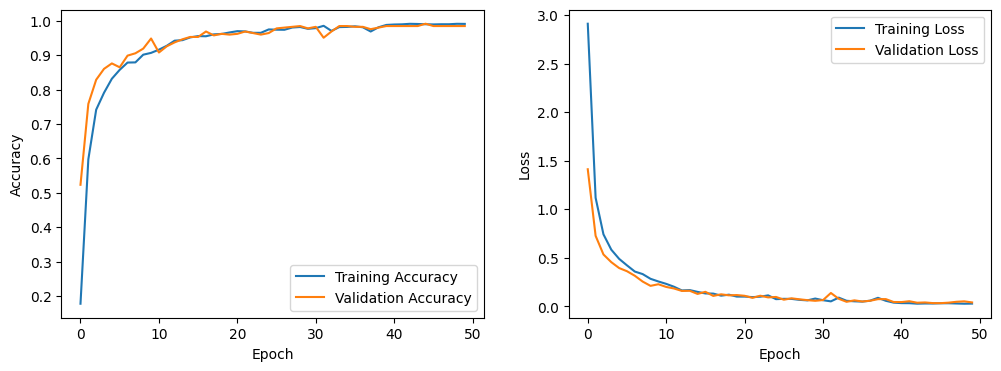

In [14]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Save the tokenizer
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the label encoder
with open('label_encoder.pickle', 'wb') as f:
    pickle.dump(label_encoder, f)